In [34]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [35]:
import numpy as np
import pandas as pd

In [36]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect 

In [38]:
#Create engine 
engine = create_engine('sqlite:///Resources/hawaii.sqlite')
conn = engine.connect()
Base = automap_base()

In [39]:
# reflect an existing database into a new model
# reflect the tables
Base.prepare(engine, reflect=True)

In [40]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [41]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [42]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)
inspector = inspect(engine)

In [43]:
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [44]:
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

<Figure size 360x288 with 0 Axes>

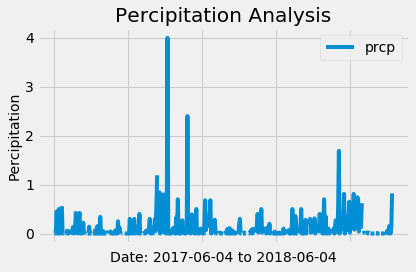

In [136]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
last_yr_date = dt.date(2018, 6, 4) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.prcp, measurement.date)\
    .filter( measurement.date >= last_yr_date)\
    .order_by(measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation, columns=['prcp', 'date'])
# This following method will also save results as Pandas DataFrame:     
    # prcp_df = pd.read_sql(precipitation.statement, precipitation.session.bind)

# Sort the dataframe by date
prcp_df.sort_values(['date'])

# Use Pandas Plotting with Matplotlib to plot the data
fig1 = plt.figure(figsize=(5,4))
prcp_df.plot('date', 'prcp')
plt.grid(True)
plt.xlabel("Date: 2017-06-04 to 2018-06-04", fontsize=14)
plt.ylabel("Percipitation", fontsize=14)
plt.title("Percipitation Analysis")
plt.legend
plt.tight_layout()
plt.show()
plt.close(fig1)

![precipitation](Images/precipitation.png)

In [138]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,412.000000
mean,0.117549
std,0.294210
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,4.000000


In [163]:
# How many stations are available in this dataset?
session.query(measurement).group_by(measurement.station).count()

9

In [170]:
# What are the most active stations?
# List the stations and the counts in descending order.
active = session.query(measurement.station, func.count(measurement.tobs))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.tobs)\
    .desc()).all()
most_active = active[0][0]
most_active

'USC00519281'

In [211]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperatures = session.query(measurement.station, measurement.date, measurement.tobs)\
    .filter(measurement.station == most_active)\
    .filter(measurement.date > last_yr_date)\
    .order_by(measurement.date).all()
most_active_temp = pd.DataFrame(temperatures, columns=['station', 'date', 'temp'])
lowest_temp = most_active_temp['temp'].min()
highest_temp = most_active_temp['temp'].max()
avg_temp = most_active_temp['temp'].mean()
avg_temp = round(avg_temp, 2)

print(f"The lowest temperature recorded was {lowest_temp}F" +'\n'+
      f"The highest temperature recorded was {highest_temp}F" +'\n'+
      f"The average temperature recorded was {avg_temp}F")

The lowest temperature recorded was 69.0F
The highest temperature recorded was 83.0F
The average temperature recorded was 76.11F


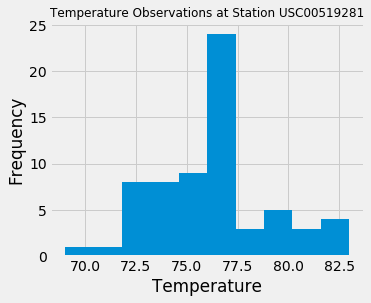

In [224]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
fig2 = plt.figure(figsize=(5,4))
plt.grid(True)
plt.hist(most_active_temp['temp'])
bin_size = 12
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations at Station USC00519281', fontsize = 12)
plt.show()
plt.close(fig2)

In [225]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [228]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_avg_temp = (calc_temps('2016-06-04', '2016-06-24'))

yerr_val = trip_avg_temp[0][2] - trip_avg_temp[0][0]

# Y value is the average temperature for the trip's date range; X is zero since we only need one bar
y = [trip_avg_temp[0][1]]
x = 0

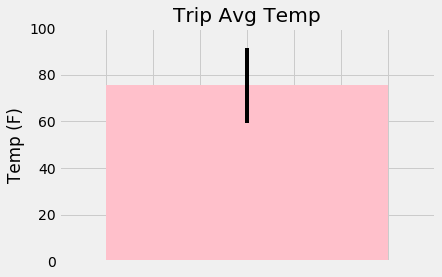

In [242]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig3 = plt.figure(figsize = (5,4))
fig, ax = plt.subplots()

ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")

ax.bar(x, y, width=1.5, color="pink", yerr=yerr_val)
ax.set_xlim(0, 1)
ax.set_ylim(0, 100)
ax.set_xbound(lower=-1, upper=1)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.close(fig3)
plt.show()

## Optional Challenge Assignment

In [243]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


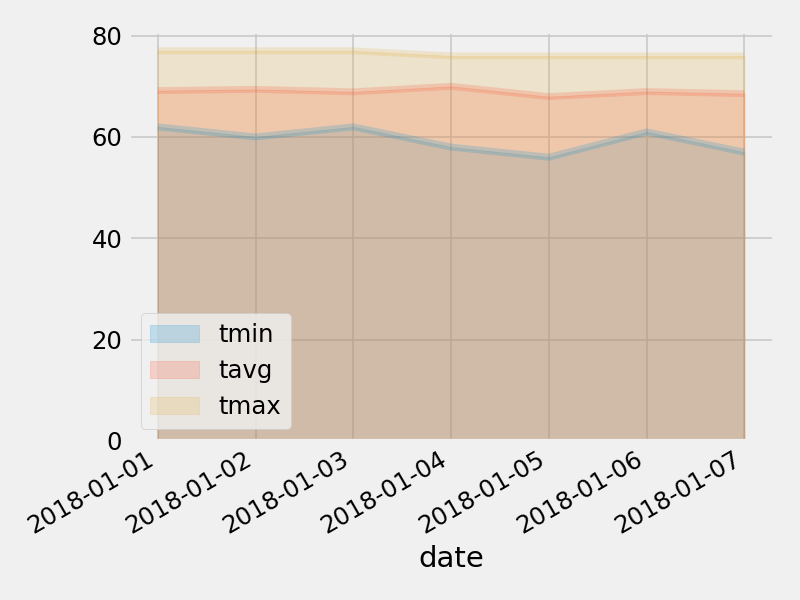

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
